In [1]:
import modelling_lib_rodrixx as mod
import preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

import xgboost as xgb

from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

import mlflow

In [2]:
dataframes_path = os.path.join(os.getcwd(), 'dataframes')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [3]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1980_to_2021.pkl'))

In [4]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,1,Kareem Abdul-Jabbar,C,32,LAL,82,-10,38.3,10.2,16.9,...,7,2,1,0.732,82,2,1.000,147,0.665,221
1,2,Tom Abernethy,PF,25,GSW,67,-10,18.2,2.3,4.7,...,32,54,41,0.293,82,44,0.817,0,0.000,221
2,3,Alvan Adams,C,25,PHO,75,-10,28.9,6.2,11.7,...,11,12,12,0.671,82,6,0.915,0,0.000,221
3,4,Tiny Archibald,PG,31,BOS,80,80,35.8,4.8,9.9,...,33,31,20,0.744,82,1,0.976,2,0.009,221
4,5,Dennis Awtrey,C,31,CHI,26,-10,21.5,1.0,2.3,...,21,56,42,0.366,82,38,0.317,0,0.000,221


In [5]:
cols_tot = [col for col in df.columns if '_tot' in col]
cols_to_drop = ['Rk', 'G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm']
cols_to_drop += cols_tot
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
col_to_ohe = 'Pos'

In [6]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('OHE', prep.OHE(col_to_ohe)),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [7]:
df = pipe_clean.fit_transform(df)

In [8]:
df.head()

,,Age,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,2P_pg,2PA_pg,...,VORP_rank,%W,%W_rank,%G,Share,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1980,32,38.3,10.2,16.9,0.604,0.0,0.0,0.000,10.2,16.9,...,1,0.732,2,1.000,0.665,1,0,0,0,0
2,1980,25,18.2,2.3,4.7,0.481,0.0,0.0,0.000,2.3,4.7,...,41,0.293,44,0.817,0.000,0,1,0,0,0
3,1980,25,28.9,6.2,11.7,0.531,0.0,0.0,0.000,6.2,11.6,...,12,0.671,6,0.915,0.000,1,0,0,0,0
4,1980,31,35.8,4.8,9.9,0.482,0.1,0.2,0.222,4.7,9.7,...,20,0.744,1,0.976,0.009,0,0,1,0,0
5,1980,31,21.5,1.0,2.3,0.450,0.0,0.0,0.000,1.0,2.3,...,42,0.366,38,0.317,0.000,1,0,0,0,0


In [9]:
len(df[df.index.get_level_values(1) > 2016]) / len(df)

0.14811240420096508

In [10]:
val_df = df[df.index.get_level_values(1) > 2016]
dev_df = df[df.index.get_level_values(1) <= 2016]

In [11]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [12]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [13]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [14]:
mlflow.set_experiment('NBA MVP prediction Ensemble')

<Experiment: artifact_location='file:///C:/Users/marcr/OneDrive/Documents/Data%20Science/NBA%20Project/mlruns/6', experiment_id='6', lifecycle_stage='active', name='NBA MVP prediction Ensemble', tags={}>

In [15]:
params_1 = {
    'colsamples_bytree': .7,
    'learning_rate': .2,
    'max_depth': 3,
    'n_estimators': 150,
    'subsample': .7,
    'random_state': 23
}

params_2 = {
    'max_depth': 8,
    'max_features': .5,
    'min_samples_split': 10,
    'n_estimators': 220,
    'random_state': 23
}

In [16]:
with mlflow.start_run():
    estimator_1 = xgb.XGBRegressor(**params_1)
    estimator_2 = RandomForestRegressor(**params_2)

    model = VotingRegressor([('xgb', estimator_1), ('rf', estimator_2)], weights = [.7, .3], verbose = True)

    cv_scores = cross_validate(model, X_train, y_train, scoring = ('neg_root_mean_squared_error', 'r2'), cv = 10)

    model.fit(X_train, y_train)

    params = model.get_params()

    predicted_targets = mod.predict_model(model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_ens(params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list))

[22:37:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "colsamples_bytree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[Voting] ...................... (1 of 2) Processing xgb, total=  17.7s
[Voting] ....................... (2 of 2) Processing rf, total= 1.2min
[22:38:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "colsamples_bytree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[Voting] ...................... (1 of 2) Process

2022/10/15 22:50:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\marcr\AppData\Local\Temp\tmpklju1za4\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


In [17]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.012527,0.014481,0.027089
R2,0.993118,0.975811,0.768340


In [18]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

In [19]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.495756
173,2017,James Harden,0.746,0.607533
261,2017,Kawhi Leonard,0.495,0.608033
221,2017,LeBron James,0.330,0.346398
425,2017,Isaiah Thomas,0.080,0.163684
98,2017,Stephen Curry,0.051,0.182979
16,2017,Giannis Antetokounmpo,0.007,0.074410
453,2017,John Wall,0.007,0.070598
100,2017,Anthony Davis,0.002,0.160997


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.951652
249,2018,LeBron James,0.731,0.449468
122,2018,Anthony Davis,0.441,0.231441
298,2018,Damian Lillard,0.205,0.118809
508,2018,Russell Westbrook,0.075,0.169517
16,2018,Giannis Antetokounmpo,0.074,0.133799
143,2018,Kevin Durant,0.065,0.204715
130,2018,DeMar DeRozan,0.032,0.007724
7,2018,LaMarcus Aldridge,0.006,0.045007


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.770239
207,2019,James Harden,0.768,0.630920
184,2019,Paul George,0.352,0.094863
270,2019,Nikola Jokić,0.210,0.190950
124,2019,Stephen Curry,0.173,0.128648
305,2019,Damian Lillard,0.068,0.170570
155,2019,Joel Embiid,0.049,0.099288
150,2019,Kevin Durant,0.025,0.161629
301,2019,Kawhi Leonard,0.013,0.197184


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.746038
251,2020,LeBron James,0.746,0.476569
199,2020,James Harden,0.363,0.478403
134,2020,Luka Dončić,0.198,0.057500
294,2020,Kawhi Leonard,0.166,0.140883
123,2020,Anthony Davis,0.081,0.343693
396,2020,Chris Paul,0.026,0.010999
297,2020,Damian Lillard,0.023,0.203085
262,2020,Nikola Jokić,0.018,0.048788


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.553252
146,2021,Joel Embiid,0.580,0.151224
116,2021,Stephen Curry,0.449,0.199880
12,2021,Giannis Antetokounmpo,0.345,0.347914
396,2021,Chris Paul,0.138,0.012908
130,2021,Luka Dončić,0.042,0.121480
297,2021,Damian Lillard,0.038,0.225598
421,2021,Julius Randle,0.020,-0.008128
439,2021,Derrick Rose,0.010,0.000647


No contenders results:


Player  Share  PredShare
Rk  Season                                
1   2017    Álex Abrines    0.0   0.000474
    2018    Álex Abrines    0.0   0.000474
2   2019      Quincy Acy    0.0   0.000219
    2020     Bam Adebayo    0.0   0.007313
    2021    Jaylen Adams    0.0   0.000480
...                  ...    ...        ...
537 2018    Tyler Zeller    0.0   0.000325
538 2018     Paul Zipser    0.0   0.000307
    2021      Trae Young    0.0   0.018182
539 2018      Ante Žižić    0.0   0.013619
    2021     Cody Zeller    0.0   0.000169

[1593 rows x 3 columns]

In [20]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
66,2017,Jimmy Butler,0.0,0.155979
84,2020,Devontae Cacok,0.0,0.103727
140,2021,Kevin Durant,0.0,0.149427
156,2017,Rudy Gobert,0.0,0.140045
165,2017,Draymond Green,0.0,0.102936
177,2020,Rudy Gobert,0.0,0.107072
240,2018,Kyrie Irving,0.0,0.102691
451,2018,Ben Simmons,0.0,0.116502
484,2018,Karl-Anthony Towns,0.0,0.116002


In [21]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

(<Figure size 2880x2880 with 6 Axes>, <Figure size 2880x2880 with 6 Axes>)

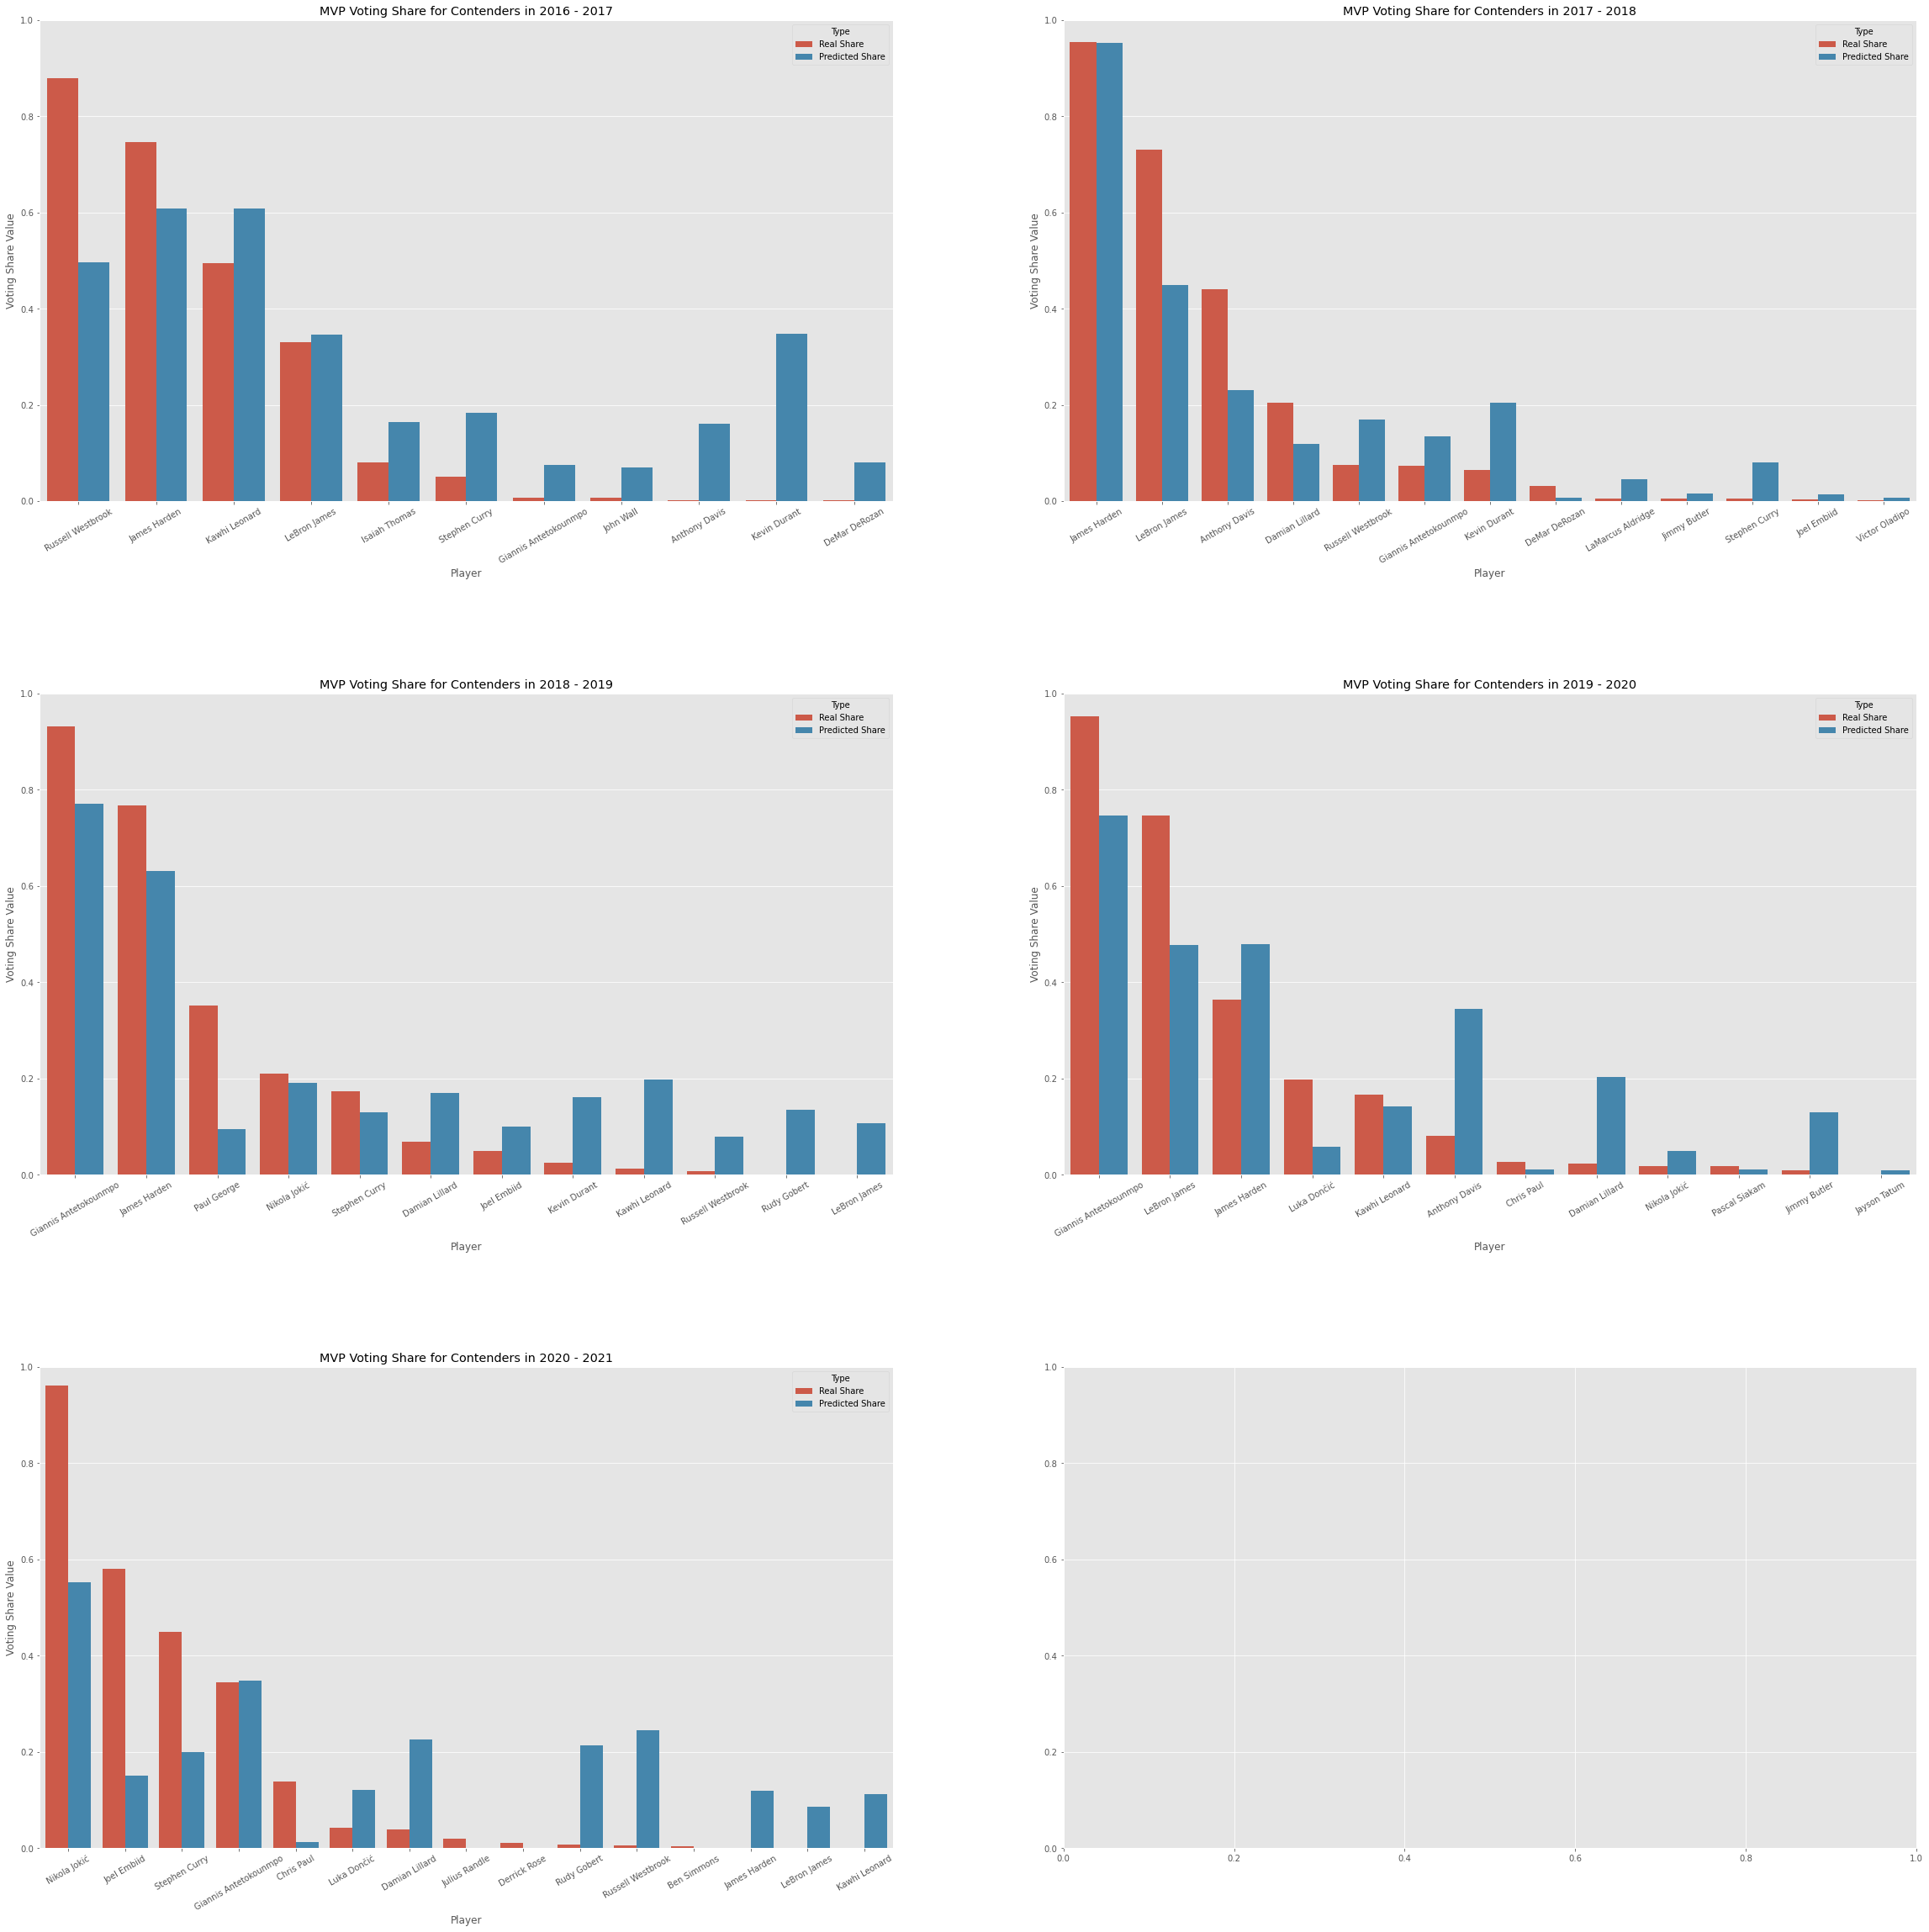

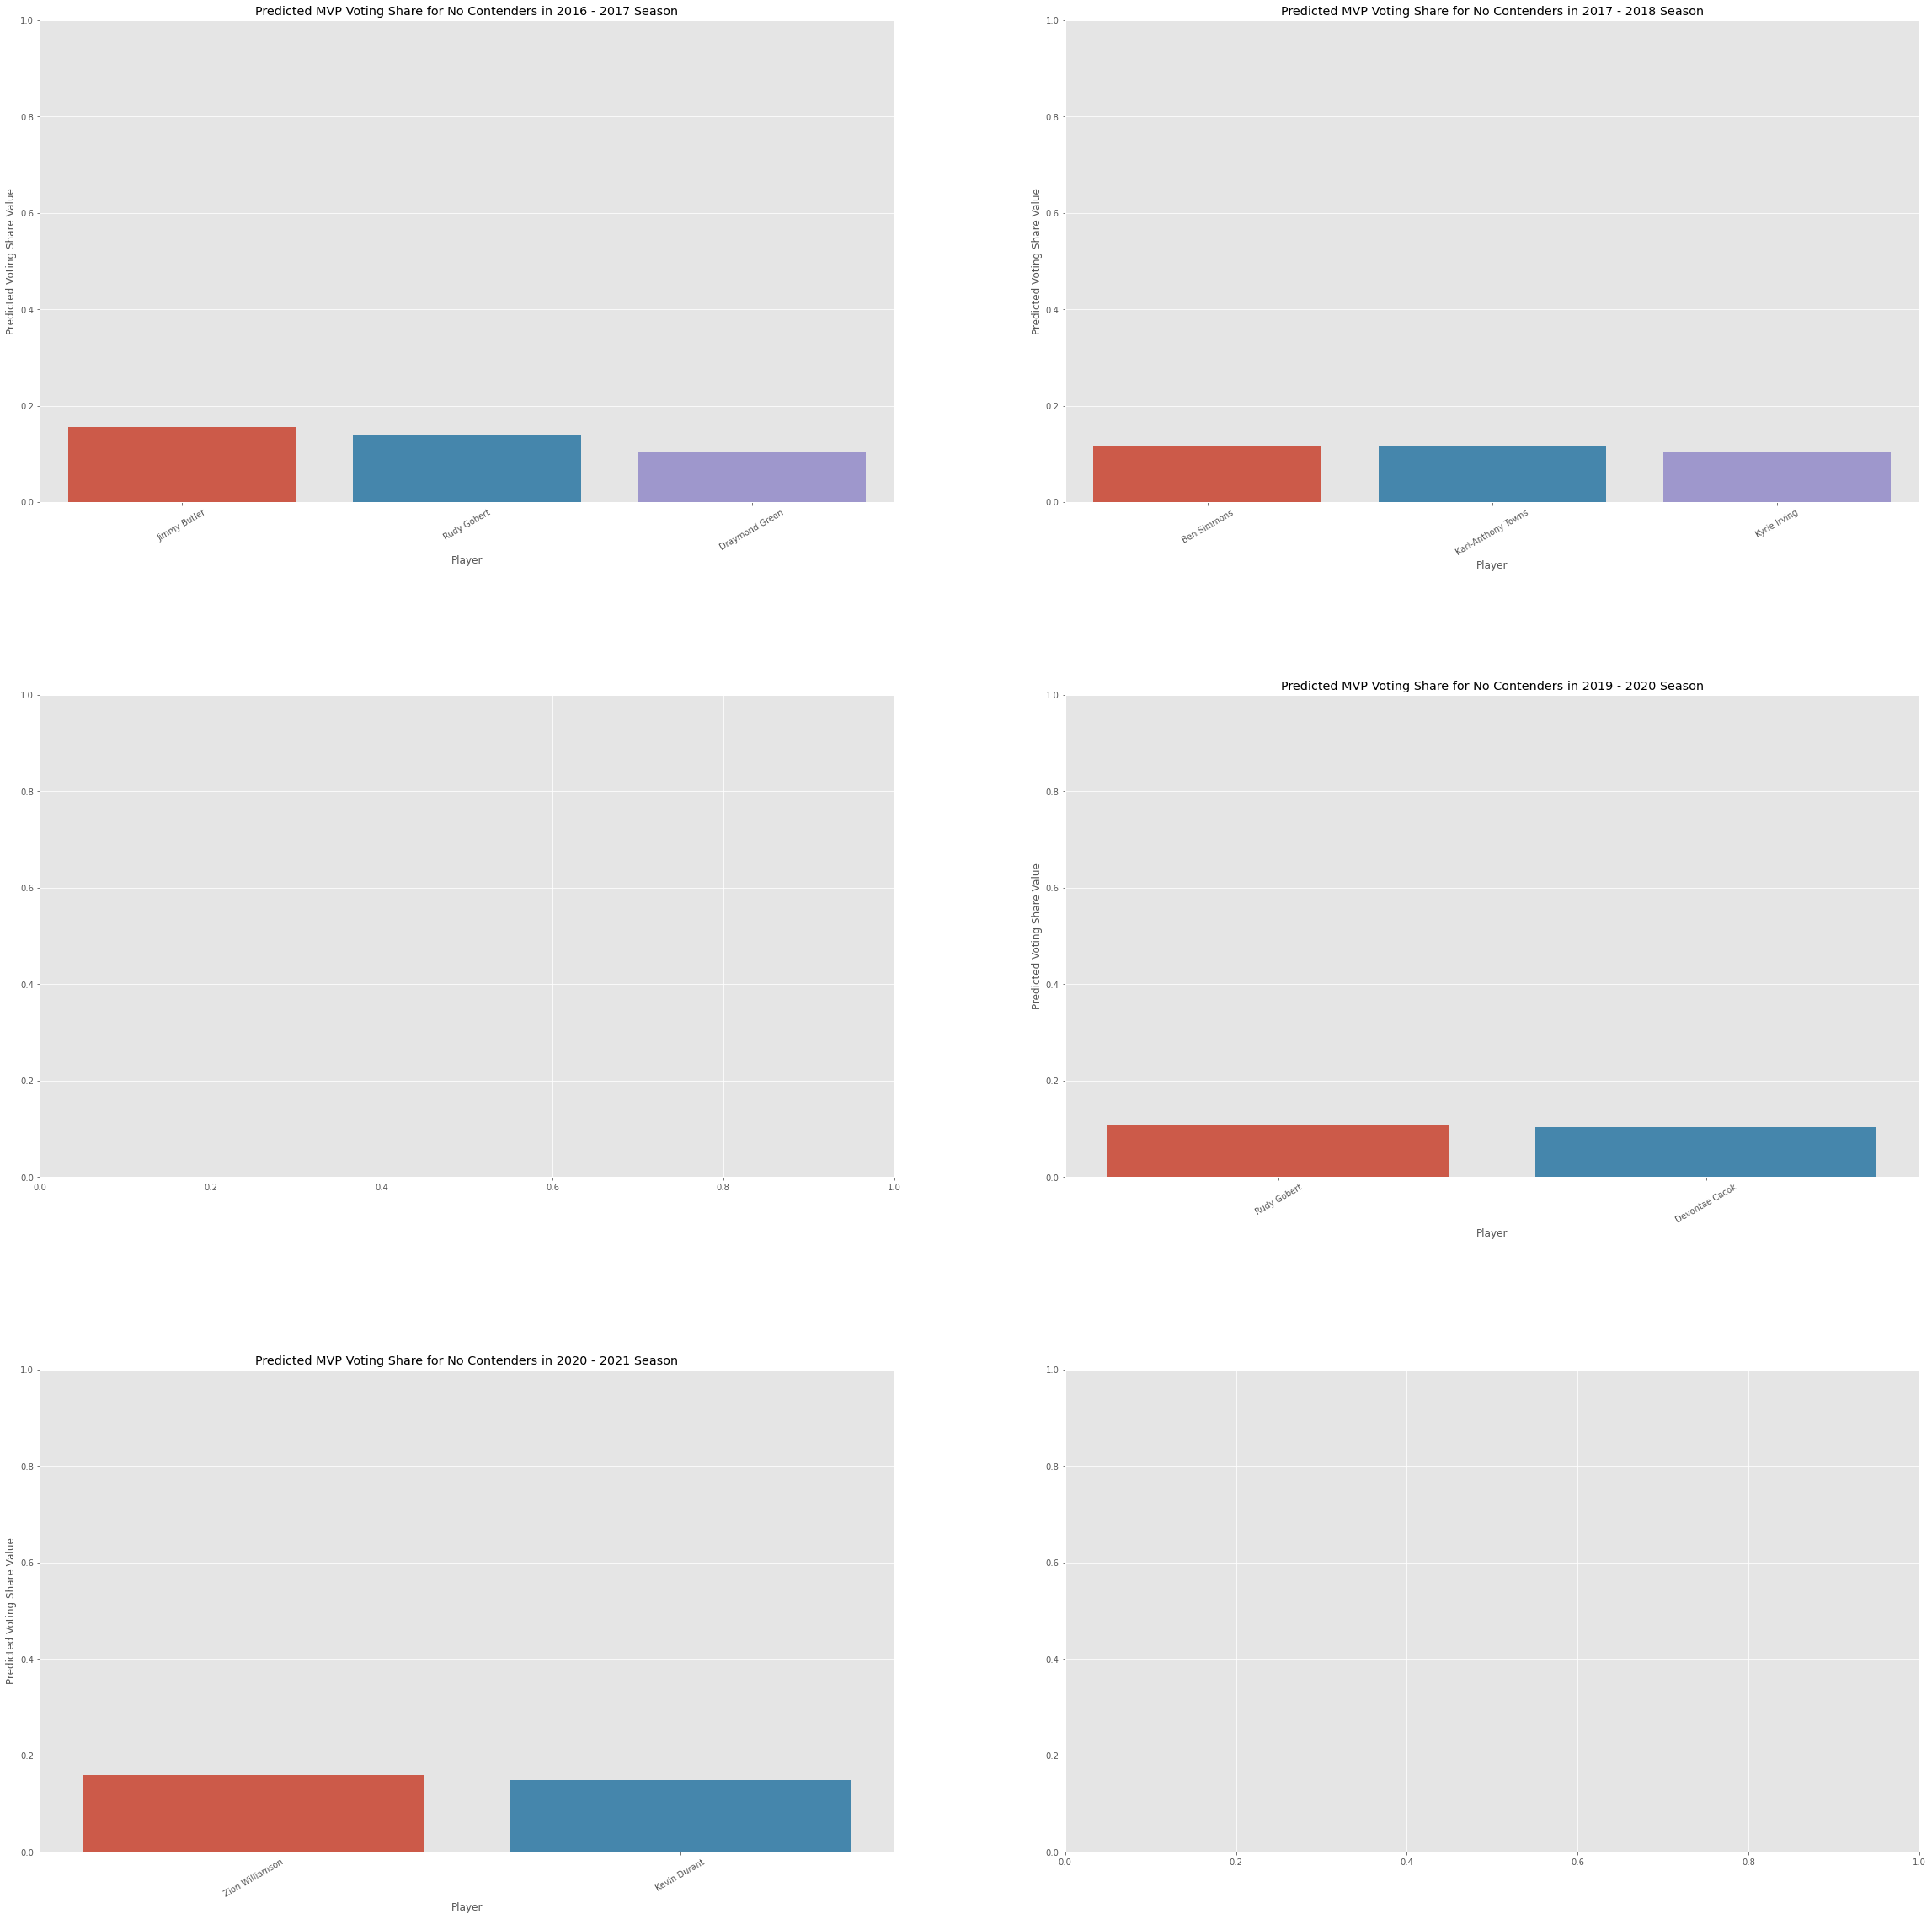

In [22]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)